<a href="https://colab.research.google.com/github/Balonglongz/github-codespaces-demo/blob/main/Topic%2007%20MT2%20SP23%20for%20Skills%20OH%20solution%20ex%20289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 2, Spring 2023: Better Reads

_Version history:_
- 1.0.1 (Sun Apr 2): Corrected typo in Ex. 7 demo
- 1.0: Initial release

*All of the header information is important. Please read it.*

**Topics, number of exercises:** This problem builds on your knowledge of Numpy, pandas, database organization, graph abstractions, and basic Python (for interfacing with other Python libraries). It has **11** exercises, numbered 0 to **10**. There are **21** available points. However, to earn 100% the threshold is **12** points. (Therefore, once you hit **12** points, you can stop. There is no extra credit for exceeding this threshold.)

**Free points!** This exam includes one exercise, Exercise 3, whose points are "**free**." However, to get these points you need to read some text and _submit the notebook to the autograder at least once_.

**Exercise ordering:** Each exercise builds logically on previous exercises, but you may solve them in any order. Exercises are **not** necessarily ordered by difficulty, but higher point values usually imply more difficult tasks.

**Demo cells:** Code cells that start with the comment `### define demo inputs` will load results from prior exercises applied to the entire data set and use those to build demo inputs. These must be run for later demos to work properly but they do not affect the test cells. The data loaded by these cells may be large (at least in terms of human readability). You are free to inspect them, but we did not print them in the starter code.

**Debugging you code:** Right before each exercise test cell, there is a block of text explaining the variables available to you for debugging. You may use these to test your code and can print/display them as needed (careful when printing large objects, you may want to print the head or chunks of rows at a time).

**Exercise point breakdown:**

- Exercise 0: **2** points
- Exercise 1: **1** point
- Exercise 2: **3** points
- Exercise 3: **2** point **FREEBIE! Submit to record them**
- Exercise 4: **1** point
- Exercise 5: **2** points
- Exercise 6: **2** points
- Exercise 7: **1** point
- Exercise 8: **3** points
- Exercise 9: **2** points
- Exercise 10: **2** points

**Final reminders:**

- Submit after **every exercise**
- Review the generated grade report after you submit to see what errors were returned
- Stay calm, skip problems as needed, and take short breaks at your leisure

# Background: Better Reads #

[Goodreads](https://www.goodreads.com/) is a website devoted to curating user-generated book reviews. You'll do some elementary data-mining to uncover "communities" of users who like the same books. Such insights might help users find like-minded communities and generate better book recommendations.

**Overall workflow.** This notebook has six (6) parts with about 1-3 exercises each.
* **Part A:** Analyze user-book interactions [SQL, pandas]
* **Part B:** Power-law analysis [pandas, Numpy]
* **Part C:** Edge lists, NetworkX, and graph clusters [Python, graphs]
* **Part D:** Finding communities via graph clustering [SQL, pandas]
* **Part E:** Identifying "top reads" by community [pandas]
* **Part F:** Merging inventory metadata [pandas]

# Getting started (modules) #

Skim the code cell below and then run it. Take note of the standard preloaded modules, `numpy as np`, `pandas as pd`, and `sqlite3 as db`, any or all of which you may need to construct your solutions.

The other functions are used by our demo and testing code. You can ignore them unless an exercise asks you to do otherwise.

In [1]:
# uncomment in Google Colab
# !python --version
!pip install dill
import dill as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00


In [2]:
### Global Imports
%load_ext autoreload
%autoreload 2

# Standard Python modules
import sys
import numpy as np
import pandas as pd
import sqlite3 as db
import networkx as nx

In [3]:
### Global Imports
# Some functionality needed by the notebook and demo cells:
from pprint import pprint, pformat
import math


# === Messages === #

def status_msg(s, verbose=True, **kwargs):
    if verbose:
        print(s, **kwargs)


# === Input/output === #

# def load_df_from_file(basename, dirname='resource/asnlib/publicdata/', abort_on_error=False, verbose=False):
def load_df_from_file(basename, dirname='', abort_on_error=False, verbose=False):
    from os.path import isfile
    from dill import loads
    from pandas import DataFrame
    df = DataFrame()
    filename = f"{dirname}{basename}"
    status_msg(f"Loading `DataFrame` from '{filename}'...", verbose=verbose)
    if isfile(filename):
        try:
            with open(filename, "rb") as fp:
                df = loads(fp.read())
            status_msg(f"  ==> Done!", verbose=verbose)
        except:
            if abort_on_error:
                raise
            else:
                df = DataFrame()
                status_msg(f"  ==> An error occurred.", verbose=verbose)
    return df

# ==== Plotting ==== #
def plot_series_loglog(series, ax=None, figsize=(8, 8/16*9), **kwargs):
    from matplotlib.pyplot import figure, gca
    if ax is None:
        fig = figure(figsize=figsize)
        ax = gca()
    x = series.index
    y = series.values
    ax.loglog(x, y, '.', **kwargs)
    return ax

In [4]:
# import files
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/demo_ex2.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/demo_ex8.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/ex1-user_id.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/ex2-log2bin_count.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/ex8-input.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/goodreads.db
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tc_2
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tc_8
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tc_9
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/ex8-output.df
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/ex8-topreads.df

!mkdir tester_fw
%cd tester_fw

!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tester_fw/__init__.py
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tester_fw/test_utils.py
!wget https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/tester_fw/testers.py

%cd ..

--2023-10-22 02:33:45--  https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/demo_ex2.df
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 966 [application/octet-stream]
Saving to: ‘demo_ex2.df’

demo_ex2.df         100%[===================>]     966  --.-KB/s    in 0s      

2023-10-22 02:33:46 (18.9 MB/s) - ‘demo_ex2.df’ saved [966/966]

--2023-10-22 02:33:46--  https://raw.githubusercontent.com/gt-cse-6040/topic_07_MT2_SP23_289/main/demo_ex8.df
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6411 (6.3K) [appl

In case it's helpful, here are the versions of Python and standard modules you are using:

In [5]:
print("* Python version: {}".format(sys.version.replace('\n', ' ')))
print(f"* Numpy version: {np.__version__}")
print(f"* pandas version: {pd.__version__}")
print(f"* sqlite3 version: {db.version}")

* Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
* Numpy version: 1.23.5
* pandas version: 1.5.3
* sqlite3 version: 2.6.0


## pandas versus SQL ##

The actual Goodreads data is provided via a SQLite3 database. However, only some exercises _require_ SQL; most exercises were designed with pandas in mind.

Nevertheless, even some of the pandas exercises can be solved using SQL. The cell below defines the function, `dfs_to_conn`, which can be used to create in-memory database connections. If you pass in a dictionary mapping table names to pandas `DataFrame` objects, then `dfs_to_conn` will return a `sqlite3` connection with all of the data in the `DataFrame` objects available under the names given as keys. You are also free to write to the in-memory database by creating tables, inserting, deleting, updating records, etc. Anything that SQLite3 allows should work.

**Example:**

```python
    my_df = pd.DataFrame({'A':[1,2,3], 'B': [4,5,6], 'C':['x', 'y', 'z']})
    print(my_df)
    #    A  B  C
    # 0  1  4  x
    # 1  2  5  y
    # 2  3  6  z
    conn = dfs_to_conn({'my_table': my_df})
    cur = conn.cursor()
    cur.execute('select A, B, C from my_table')
    result = cur.fetchall()
    conn.close()
    print(result) # list of tuples, each tuple is a row
    #[(1, 4, 'x'), (2, 5, 'y'), (3, 6, 'z')]
```

In [6]:
def dfs_to_conn(conn_dfs, index=False):
    import sqlite3
    conn = sqlite3.connect(':memory:')
    for table_name, df in conn_dfs.items():
        df.to_sql(table_name, conn, if_exists='replace', index=index)
    return conn

# Goodreads Data (`grdbconn`) #

Some of the Goodreads data is stored in a SQLite3 database. The code cell below opens a read-only connection to it named **`grdbconn`**.

For now, don't worry about what's there. We will explain any tables you need in the exercises that use them.

In [7]:
# Goodreads database connection:
grdbconn = db.connect('file:goodreads.db?mode=ro', uri=True)

# Part B: Power laws #

> Includes Exercise 2 (3 points).

Many types of real-world data have _**power law distributions**_. Roughly speaking, a probability density $f(x)$ is a power law if it behaves like $\dfrac{1}{x^d}$ for some constant $d$ when $x$ is "large," i.e., as one approaches the tail of the distribution. Let's see if there are any power laws in our data.

For instance, suppose you have a pandas `Series` that shows, for each user, how many books they interacted with:

In [8]:
ux_counts = load_df_from_file(f"ex1-user_id.df").set_index('user_id')['count']
ux_counts

user_id
175       349
1251      146
1369      127
1764      278
1773      225
         ... 
874199     12
874412     93
874916     87
875838     55
876114     57
Name: count, Length: 2000, dtype: int64

The index is a user ID and the value is an integer count of how many interaction-rows are associated with them.

## **Ex. 2 (3 pts)**: `log2bin_count` ##

Given a `Series` object holding values that can range from 1 to $n$, inclusive, we wish to count how many of those integers lie within the _log-two bins_,

* $[1, 2)$: that is, starting at one up to but _excluding_ 2;
* $[2, 4)$: starting at two up to but _excluding_ 4;
* $[4, 8)$: starting at 4 up to but _excluding_ 8;
* ...
* and $\left[ 2^{k-1}, 2^k \right)$: starting at $2^{k-1}$ up to but excluding $2^k$, where $2^k$ is the first power of two greater than $n$.

Complete the function,
```python
def log2bin_count(series):
    ...
```
to compute these counts.

**Inputs:** The input `series` is a pandas `Series`-object holding the values.

**Your tasks** will involve, most likely, these steps:
- Determine what the bins need to be.
- Count the number of values in each bin.
- Exclude any empty bins, i.e., those with _no_ values.

**Outputs:** Your function should return a `DataFrame` with two columns:
1. `bin_start`: The value of the left edge of a bin, which are integers starting at 1 and all of the form $2^i$.
2. `count`: The number of values in `series` that lie in $\left[ 2^i, 2^{i+1} \right)$, also an integer.

See the demo below for an example.

**Additional notes and hints.**
1. You may assume all input values are integers greater than or equal to 1.
1. Given a value $x$, the next largest power of two is $2^k$ where $k = \lceil \log_2 x \rceil + 1$.
1. A helpful function is [`pandas.cut` (`pd.cut`)](https://pandas.pydata.org/docs/reference/api/pandas.cut.html), but you certainly do not have to use it.
1. Recall that you should _omit_ empty bins.

**Example/demo:** Suppose the input `Series` looks like the following:

In [9]:
### Define demo inputs ###

demo_series_ex2 = load_df_from_file('demo_ex2.df').set_index('user_id')['count']
display(demo_series_ex2)

user_id
752564     76
365745    373
405247    385
83287     142
363597    133
676898     49
795294     78
736928     19
594854     37
62913     119
Name: count, dtype: int64

Then a correct solution would produce:

|   bin_start |   count |
|------------:|--------:|
|          64 |       3 |
|         256 |       2 |
|         128 |       2 |
|          32 |       2 |
|          16 |       1 |

There is just one input value in $[16, 32)$, namely, the value `49`. But in the bin $[64, 128)$, there are three input values: `76`, `78`, and `119`.

In [16]:
## Kathie Solution
def log2bin_count(series):
    ### BEGIN SOLUTION
    # Input: series that contains integers
    # Goal: Divide the integers into bins [2^0,2^i+1]. Return a dataframe that has 2 columns: bin_start, count. Remove empty bins
    # Strategy
    # 1. Determine what the bins need to be.
    # 2. Count the number of values in each bin.
    # 3. Exclude any empty bins, i.e., those with no values.
    # >> Find max value in series
    # >> Create bins through while loop until ending value is greater than max value found in Step 1
    # >> Use hint pd.cut to series values into bins
    # >> Remove any empty values
    # >> Count the number of occurences
    # >> Create a dataframe from step 5 results
    # >> Return dataframe

    max_val = series.max()

    ending_val = 0
    bin_list = []
    i = 0

    while ending_val < max_val:
      bin_pair = (2**i,2**(i+1))
      bin_list.append(bin_pair)
      ending_val = 2**(i+1)
      i += 1

    bins = pd.IntervalIndex.from_tuples(bin_list,closed='left')
    cut_result = pd.cut(series, bins)
    cut_result = cut_result.dropna()

    from collections import Counter
    counted_result = Counter(cut_result)

    df_list = []
    for interval in counted_result:
      df_row = [interval.left,counted_result[interval]]
      df_list.append(df_row)

    df_final = pd.DataFrame(df_list,columns=['bin_start','count'])

    return df_final




### demo function call ###
log2bin_count(demo_series_ex2)

,bin_start,count
0,64,3
1,256,2
2,128,2
3,32,2
4,16,1


In [ ]:
### Exercise 2 solution
def log2bin_count(series):
    ### BEGIN SOLUTION
    from pandas import cut
    bins = make_log2bins(series)
    bin_owners = cut(series, bins=bins, labels=bins[:-1], right=False).astype(int)
    counts = bin_owners.value_counts()
    df = counts.to_frame().reset_index()
    df = df.rename(columns={'index': 'bin_start', 0: 'count'})
    return df

def make_log2bins(series):
    from numpy import log2, ceil, arange
    pmax = int(ceil(log2(series.max()))) + 1
    return 2**arange(pmax)
    ### END SOLUTION

### demo function call ###
log2bin_count(demo_series_ex2)

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 2. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [17]:
### test_cell_ex2
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_2',
    'func': log2bin_count, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'series': {
            'dtype': 'series',
            'check_modified': True,
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

Passed! Please submit.


**RUN ME:** A correct implementation of `log2bin_count`, when run on `ux_counts` from the full Goodreads dataset, would produce the following:

In [ ]:
ux_counts

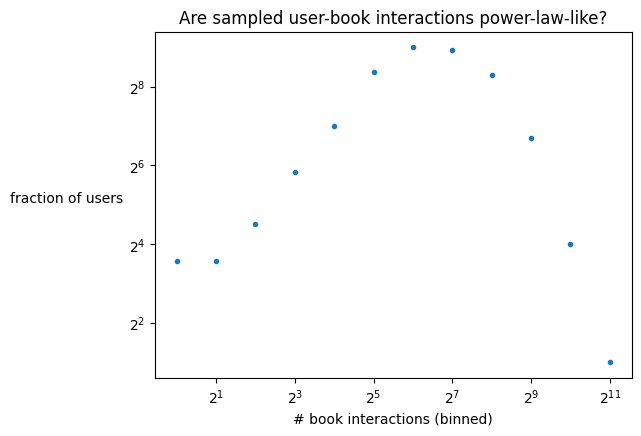

In [18]:
ux_counts_log2bins = load_df_from_file('ex2-log2bin_count.df')
ax = plot_series_loglog(ux_counts_log2bins.set_index('bin_start')['count'], base=2)
ax.set_xlabel('# book interactions (binned)')
ax.set_ylabel('fraction of users', rotation=0, horizontalalignment='right')
ax.set_title('Are sampled user-book interactions power-law-like?')
ax.set_aspect(1.0)

> **Aside (skip if pressed for time):** These interactions do, indeed, appear to follow a power law in the tail of the distribution. In fact, the data in this notebook is a relatively small sample of the full dataset, which consists of hundreds of millions of interactions and has an even longer tail consistent with a power law.

## **Ex. 8 (3 pts):** `get_topreads_by_community` ##

Suppose we merge the community information into the interactions database. Can we then identify which books each community is "the most interested in?" Complete the following function to help answer this question:

```python
def get_topreads_by_community(xcdf, rank):
    ...
```

**Inputs:** There are two inputs:
1. `xcdf` is a `DataFrame` with the following columns:
  * `user_id`: A user ID (integer)
  * `book_id`: A book ID (integer) that this user read
  * `comm_id`: The community ID to which the user belongs (integer)
2. `rank` is an integer indicating how many of the top books we want to return. For instance, if `rank=5`, then we want results for just the top 5 books in each community.

**Your task:** For each community, calculate what _percentage_ of its users read each book. That is, we would like to be able to see something like "in Community 2, 25% of the users read book 238." We then want to identify the top `rank` books.

There are several strategies for this exercise, but you might consider something along these lines.
- Determine the number of unique users in each community. You need this information to get percentages.
- Determine how many users read each book by community.
- Normalize these counts by the community size.
- Sort and return the results, retaining just the top `rank` books in each community.

**Outputs:** Your function should return a new `DataFrame` with the following columns:
- `comm_id`: The community ID
- `book_id`: A book ID that was read in that community
- `percent`: The percentage of the community that read that book.
- `comm_size`: The number of users in the community

As noted above, return **at most** the top `rank` books per community. In the event of ties, retain books with the lowest ID. (This choice is arbitrary but will simplify your implementation.)

**Additional notes and hints:** If your code calculates a fraction, don't forget to multiply by 100 to get a percentage value for your final output.

**Example:** Consider this input dataframe and a target rank of 2:

In [20]:
### Define demo inputs ###

demo_xcdf_ex8 = load_df_from_file('demo_ex8.df').reset_index(drop=True)
demo_rank_ex8 = 2

demo_xcdf_ex8

,user_id,book_id,is_read,rating,is_reviewed,comm_id
0,793590,996,1,4,0,0
1,619091,6989,1,5,0,5
2,135105,1386,1,5,0,5
3,776616,461,1,4,0,0
4,172315,997,1,4,0,3
...,...,...,...,...,...,...
95,614807,1574,1,4,0,5
96,405247,996,1,5,1,0
97,181951,1604,1,4,0,3
98,124016,944,1,5,0,5


From the demo input shown above, your function should return:

|   comm_id |   book_id |   percent |   comm_size |
|----------:|----------:|----------:|------------:|
|         0 |       821 |   7.89474 |          38 |
|         0 |       536 |   5.26316 |          38 |
|         3 |       938 |  12.5     |          32 |
|         3 |       943 |   9.375   |          32 |
|         5 |      1386 |  12       |          25 |
|         5 |      1473 |  12       |          25 |

In [46]:
# Kathie Solution
### Exercise 8 solution
def get_topreads_by_community(xcdf, rank=5):
  ### BEGIN SOLUTION
  # Input:
  # xcdf is a dataFrame witht the following columns: user_id,book_id, comm_id
  # rank is an integer

  # Goal
  # For each community,calculate wat percentage of its users read each book
  # That is, we would like to be able to see something like in community 2,
  # 25% of the users read book 238. We want to identify the top rank books
  # There are several strategies :
  # Determine the number of unique users in each community. You need this information to get percentages.
  # Determine how many users read each book by community.
  # Normalize these counts by the community size.
  # Sort and return the results, retaining just the top rank books in each community.
  #
  # Return a new DataFrame with the following columns
  # comm_id: The community ID
  # book_id: A book ID that was read in that community
  # percent: The percentage of the community that read that book.
  # comm_size: The number of users in the community

  # Strategy
  # 1. Determine the number of unique users in each community
  # 2. Determine how many users read each book by community
  # 3. Normalize these counts by the community size. Step 2 divide by Step 1
  # 4. Sort result
  # 5. Retain just the top rank books in each community

  # Solution
    xcdf_correct = xcdf[['user_id','book_id','comm_id']]

    df_comm_users = xcdf_correct[['comm_id','user_id']].drop_duplicates()
    df_unique_comm_users_count = df_comm_users.groupby('comm_id').count()
    df_unique_comm_users_count =  df_unique_comm_users_count.rename(columns={'user_id':'comm_size'})
    df_unique_comm_users_count = df_unique_comm_users_count.reset_index()

    df_comm_books_count = xcdf_correct.groupby(['comm_id','book_id']).count()
    df_comm_books_count = df_comm_books_count.rename(columns={'user_id':'book_count'})
    df_comm_books_count = df_comm_books_count.reset_index()

    df = df_comm_books_count.merge(df_unique_comm_users_count,on='comm_id')
    df['book_count'] = df['book_count'] / df['comm_size'] *100
    df = df.rename(columns={'book_count':'percent'})

    df = df.sort_values(by=['comm_id','percent','book_id'],ascending =[True,False,True])

    df = df.groupby('comm_id').head(rank)
    df =df.reset_index(drop=True)

    return df



  ### demo function call ###
get_topreads_by_community(demo_xcdf_ex8, demo_rank_ex8)

,comm_id,book_id,percent,comm_size
0,0,821,7.894737,38
1,0,536,5.263158,38
2,3,938,12.500000,32
3,3,943,9.375000,32
4,5,1386,12.000000,25
5,5,1473,12.000000,25


In [ ]:
### Exercise 8 solution
def get_topreads_by_community(xcdf, rank=5):
    ### BEGIN SOLUTION
    sizesdf = count_users_by_comm(xcdf, outcol='comm_size')
    readersdf = count_readers_by_comm(xcdf, outcol='num_read')
    df = readersdf.merge(sizesdf, on='comm_id')
    df['percent'] = df['num_read'] / df['comm_size'] * 100
    dftop = df.sort_values(['comm_id', 'percent', 'book_id'], ascending=[True, False, True]) \
              .reset_index(drop=True) \
              .groupby('comm_id').apply(lambda df: df.iloc[:rank]).reset_index(drop=True)
    return dftop[['comm_id', 'book_id', 'percent', 'comm_size']]

def count_users_by_comm(xcdf, **kwargs):
    """Count the number of users in each community."""
    cudf = xcdf[['comm_id', 'user_id']].drop_duplicates()
    return count_by_group(cudf, 'comm_id', **kwargs)

def count_readers_by_comm(xcdf, **kwargs):
    """Count the number of readers of each book in each community."""
    return count_by_group(xcdf, ['comm_id', 'book_id'], **kwargs)

def count_by_group(df, cols, outcol='count'):
    return df.groupby(cols).size().reset_index().rename(columns={0: outcol})
    ### END SOLUTION

### demo function call ###
get_topreads_by_community(demo_xcdf_ex8, demo_rank_ex8)

**RUN ME:** If your function was working correctly, you would identify these top books by community on the full dataset.

In [43]:
ex8_topreads = load_df_from_file('ex8-output.df')
ex8_topreads

,comm_id,book_id,percent,comm_size
0,0,786,28.110599,868
1,0,821,22.580645,868
2,0,943,21.428571,868
3,0,1012,20.852535,868
4,0,858,20.506912,868
5,1,25883,100.000000,2
6,1,27949,100.000000,2
7,1,52388,100.000000,2
8,1,62026,100.000000,2
9,1,62027,100.000000,2


<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 8. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [44]:
### test_cell_ex8
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_8',
    'func': get_topreads_by_community, # replace this with the function defined above
    'inputs':{ # input config dict. keys are parameter names
        'xcdf': {
            'dtype': 'df', # data type of param.
            'check_modified': True,
        },
        'rank': {
            'dtype': 'int',
            'check_modified': False
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'df',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': False, # Ignored if dtype is not df
            'check_row_order': False, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

Passed! Please submit.


# Part F (final part!): Merging inventory metadata #

> Includes Exercises 9 and 10 (2 points each).


To interpret the communities, we need to bring in some book-inventory metadata, like book titles and genres. Once we've done so, will the communities make sense?

## Genre vectors ##

The original dataset includes information on _genres_ for each book:

In [48]:
genres = pd.read_sql("SELECT * FROM Genres", grdbconn)
genres

,inv_id,genres
0,6066819,"{""fiction"": 555, ""romance"": 23, ""mystery, thri..."
1,10806008,"{""fantasy, paranormal"": 462, ""fiction"": 147, ""..."
2,11731782,"{""fantasy, paranormal"": 262, ""young-adult"": 89..."
3,9469517,"{""romance"": 136, ""fiction"": 11, ""fantasy, para..."
4,38564,"{""young-adult"": 315, ""fantasy, paranormal"": 27..."
...,...,...
9995,17061,"{""fantasy, paranormal"": 9399, ""young-adult"": 3..."
9996,23597532,"{""romance"": 68}"
9997,20336484,"{""romance"": 40, ""fiction"": 2}"
9998,7715664,"{""fantasy, paranormal"": 1597, ""romance"": 1089,..."


It's a bit messy, however: the genre information is stored as a JSON-formatted Python string encoding a **genre vector**:

In [49]:
# Inspect the very first genre entry:
print(f"* Type: `{type(genres['genres'].iloc[0])}`")
print(f"* Value: '{genres['genres'].iloc[0]}'")

* Type: `<class 'str'>`
* Value: '{"fiction": 555, "romance": 23, "mystery, thriller, crime": 10}'


This genre vector says that this particular book mixes three genres: `fiction`, `romance`, and `"mystery, thriller, crime"` (considered a single genre). Each value measures the relevance of that genre to the book.

> Roughly speaking, let's interpret `555` as meaning this book is 555 / (555+23+10) ~ 94.3% "fiction" and 23 / (555+23+10) ~ 3.9% "romance."

The database stores these as genre vectors as strings. However, we can easily convert them to Python dictionaries using the following helper function, `from_json_str`:

In [50]:
def from_json_str(s):
    """Parses the JSON string `s` and returns a Python object."""
    from json import loads
    return loads(s)


# Demo #

print("iloc 0:", from_json_str(genres['genres'].iloc[0]))
print("iloc 1:", from_json_str(genres['genres'].iloc[1]))

iloc 0: {'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}
iloc 1: {'fantasy, paranormal': 462, 'fiction': 147, 'children': 302, 'young-adult': 82, 'mystery, thriller, crime': 21}


We will treat these as (mathematical) vectors that we can "add." Here is a simple function to compute the sum of two genre vectors:

In [51]:
def add_genre_vecs(x, y):
    """Returns the sum of two genre vectors."""
    from collections import defaultdict
    z = defaultdict(int)
    for k, v in x.items():
        z[k] += v
    for k, v in y.items():
        z[k] += v
    return dict(z) # Converts into a regular Python dict

# Demo: start with two genre vectors, converted to `dict`:
demo_genre_vec_a = from_json_str(genres['genres'].iloc[0])
demo_genre_vec_b = from_json_str(genres['genres'].iloc[1])

# Add them:
add_genre_vecs(demo_genre_vec_a, demo_genre_vec_b)

{'fiction': 702,
 'romance': 23,
 'mystery, thriller, crime': 31,
 'fantasy, paranormal': 462,
 'children': 302,
 'young-adult': 82}

## **Ex. 9 (2 pts)**: `merge_genre_vecs` ##

Suppose you are given a pandas `Series` whose values are JSON strings encoding individual genre vectors. Complete the function,
```python
def merge_genre_vecs(series):
    ...
```
so that it combines the genre vectors into a single, **normalized** genre vector.

**Inputs:** The input is a `Series` object containing Python strings. Each string is a JSON-formatted genre vector.

**Your task:**
- Convert every JSON string into a Python dictionary. Use or adapt `from_json_str` from above.
- Compute the "sum" of all these dictionaries. Use or adapt `add_genre_vecs` from above.

The result of the previous two steps is a **single dictionary**. The final step is to _normalize_ this result. That is, divide each value of the result by the sum of all the values.

**Outputs:** Your function should return the normalized genre vector as a Python dictionary.

**Example:** Consider the following example input, a `Series` of JSON strings:

In [47]:
### Define demo inputs ###

demo_series_ex9 = pd.Series(
    ['{"fiction": 555, "romance": 23, "mystery, thriller, crime": 10}',
     '{"non-fiction": 534, "history, historical fiction, biography": 178, "fiction": 16, "comics, graphic": 6}',
     '{"non-fiction": 163}',
     '{"fiction": 425, "history, historical fiction, biography": 330, "young-adult": 93, "children": 190}',
     '{"fantasy, paranormal": 1}'])

print(demo_series_ex9)

0    {"fiction": 555, "romance": 23, "mystery, thri...
1    {"non-fiction": 534, "history, historical fict...
2                                 {"non-fiction": 163}
3    {"fiction": 425, "history, historical fiction,...
4                           {"fantasy, paranormal": 1}
dtype: object


A correct `merge_genre_vecs` implementation should return the dictionary,

```python
{'fiction': 0.39461172741679873,
 'romance': 0.009112519809825673,
 'mystery, thriller, crime': 0.003961965134706815,
 'non-fiction': 0.27614896988906495,
 'history, historical fiction, biography': 0.20126782884310618,
 'comics, graphic': 0.002377179080824089,
 'young-adult': 0.036846275752773376,
 'children': 0.07527733755942947,
 'fantasy, paranormal': 0.0003961965134706815}
```

In [58]:
# Kathie Solution
def merge_genre_vecs(series):
    ### BEGIN SOLUTION
    # Input: The input is a Series object containing Python strings. Each string is a JSON-formatted genre vector.
    # Goal:
    # Convert every JSON string into a Python dictionary. Use or adapt from_json_str from above.
    # Compute the "sum" of all these dictionaries. Use or adapt add_genre_vecs from above.
    # The result of the previous two steps is a single dictionary.
    # The final step is to normalize this result.
    # That is, divide each value of the result by the sum of all the values.

    # Strategy
    # 1. First, we need to convert the series input to dictionaries using from_json_str helper function
    # 2. Then, loop over dictionaries from Step 1 and add them together using 'add_genre_vec' helper function. Call this big dictionary 'genre_vec_added'
    # 3. Finally we need to normalize our dictionary by dividing each value by the sum of all values
          # 3a: Find total sum of values in our dictionary
          # 3b: Iterate over dictionary and divide each value by this total sum
    # 4. Return 'genre_vec_added' dictionary

    # Solution
    genre_vecs = series.apply(from_json_str)

    genre_vec_added = genre_vecs.iloc[0]

    for i in range(1,len(genre_vecs)):
      genre_vec_added = add_genre_vecs(genre_vec_added,genre_vecs.iloc[i])

    dictionary_values = genre_vec_added.values()
    total_sum = sum(dictionary_values)

    for genre_key in genre_vec_added:
      genre_vec_added[genre_key] = genre_vec_added[genre_key] / total_sum


    return genre_vec_added

### demo function call ###
merge_genre_vecs(demo_series_ex9)

{'fiction': 0.39461172741679873,
 'romance': 0.009112519809825673,
 'mystery, thriller, crime': 0.003961965134706815,
 'non-fiction': 0.27614896988906495,
 'history, historical fiction, biography': 0.20126782884310618,
 'comics, graphic': 0.002377179080824089,
 'young-adult': 0.036846275752773376,
 'children': 0.07527733755942947,
 'fantasy, paranormal': 0.0003961965134706815}

In [ ]:
### Exercise 9 solution
def merge_genre_vecs(series):
    ### BEGIN SOLUTION
    vec_list = series.apply(from_json_str).to_list()
    vec = merge_dicts(vec_list)
    norm_vec = normalize_dict(vec)
    return norm_vec

def merge_dicts(list_of_dicts):
    from collections import defaultdict
    merged = defaultdict(int)
    for d in list_of_dicts:
        for k, v in d.items():
            merged[k] += v
    return merged

def normalize_dict(d):
    total = sum(d.values())
    return {k: v/total for k, v in d.items()}
    ### END SOLUTION

### demo function call ###
merge_genre_vecs(demo_series_ex9)

<!-- Test Cell Boilerplate -->
The cell below will test your solution for Exercise 9. The testing variables will be available for debugging under the following names in a dictionary format.
- `input_vars` - Input variables for your solution.
- `original_input_vars` - Copy of input variables from prior to running your solution. These _should_ be the same as `input_vars` - otherwise the inputs were modified by your solution.
- `returned_output_vars` - Outputs returned by your solution.
- `true_output_vars` - The expected output. This _should_ "match" `returned_output_vars` based on the question requirements - otherwise, your solution is not returning the correct output.

In [59]:
### test_cell_ex9
from tester_fw.testers import Tester

conf = {
    'case_file':'tc_9',
    'func': merge_genre_vecs, # replace this with the function defined above
    'inputs': { # input config dict. keys are parameter names
        'series': {
            'dtype':'series', # data type of param.
            'check_modified':True,
        }
    },
    'outputs':{
        'output_0':{
            'index': 0,
            'dtype': 'dict',
            'check_dtype': True,
            'check_col_dtypes': True, # Ignored if dtype is not df
            'check_col_order': True, # Ignored if dtype is not df
            'check_row_order': True, # Ignored if dtype is not df
            'float_tolerance': 10 ** (-6)
        }
    }
}
tester = Tester(conf, key=b'jpS7W-CpqAQfuITMEQZL-yVXfhIaCkSaei-emnyRtrI=', path='')
for _ in range(70):
    try:
        tester.run_test()
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
    except:
        (input_vars, original_input_vars, returned_output_vars, true_output_vars) = tester.get_test_vars()
        raise

print('Passed! Please submit.')

Passed! Please submit.


In [ ]:
# Close database connection
try:
    grdbconn.close()
except:
    print("Goodreads database-connection may already be closed.")